## 1. Setup & Imports

Load libraries, define paths, and helper function for saving figures

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import plotly.express as px

DATA = Path("../data/processed/analytics_table.parquet")
FIGS = Path("../reports/figures")
FIGS.mkdir(parents=True, exist_ok=True)

def save_fig(fig, path: Path, *, scale: int = 2) -> None:
    """Save a Plotly figure to disk (requires `kaleido`)."""
    path.parent.mkdir(parents=True, exist_ok=True)
    fig.write_image(str(path), scale=scale)

## 2. Load Processed Data

Loads the processed analytics dataset and performs a quick structural check,
including row/column counts, data types, and missing values.

In [2]:
df = pd.read_parquet(DATA)

print("rows:", len(df), "cols:", len(df.columns))
print(df.dtypes.head(15))

missing = df.isna().sum().sort_values(ascending=False).head(10)
print(missing)

rows: 5000 cols: 18
order_id                    string[python]
user_id                     string[python]
amount                             Float64
quantity                             Int64
created_at             datetime64[ns, UTC]
status                              object
status_clean                string[python]
amount_is_missing                     bool
quantity_is_missing                   bool
date                                object
year                               float64
month                       string[python]
dow                                 object
hour                               float64
country                     string[python]
dtype: object
quantity        508
date            503
hour            503
created_at      503
year            503
month           503
dow             503
status          492
status_clean    492
amount          472
dtype: int64


## 3. Quick Audit

Provides a quick overview of the dataset structure, including column names,
data types, and non-null counts.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype              
---  ------               --------------  -----              
 0   order_id             5000 non-null   string             
 1   user_id              5000 non-null   string             
 2   amount               4528 non-null   Float64            
 3   quantity             4492 non-null   Int64              
 4   created_at           4497 non-null   datetime64[ns, UTC]
 5   status               4508 non-null   object             
 6   status_clean         4508 non-null   string             
 7   amount_is_missing    5000 non-null   bool               
 8   quantity_is_missing  5000 non-null   bool               
 9   date                 4497 non-null   object             
 10  year                 4497 non-null   float64            
 11  month                4497 non-null   string             
 12  dow                 

Summarizes key descriptive statistics for numerical columns
(count, mean, spread, and percentiles) to understand distributions.

In [4]:
df.describe()

,amount,quantity,year,hour,amount_winsor
count,4528.0,4492.0,4497.0,4497.000000,4528.0
mean,254.796674,4.999332,2025.0,11.428730,254.7866
std,142.149196,2.549051,0.0,6.925561,142.06227
min,5.24,1.0,2025.0,0.000000,9.2135
25%,130.395,3.0,2025.0,5.000000,130.395
50%,256.92,5.0,2025.0,11.000000,256.92
75%,376.3575,7.0,2025.0,17.000000,376.3575
max,499.99,9.0,2025.0,23.000000,494.7773


## 4. Questions & Results

Task 4 — Question 1: Revenue by countr

Aggregates total revenue and order counts by country
to compare overall performance across regions.

In [5]:
rev = (
    df.groupby("country", dropna=False)
    .agg(
        n=("order_id", "size"),
        revenue=("amount", "sum"),
        aov=("amount", "mean"),
    )
    .reset_index()
    .sort_values("revenue", ascending=False)
)

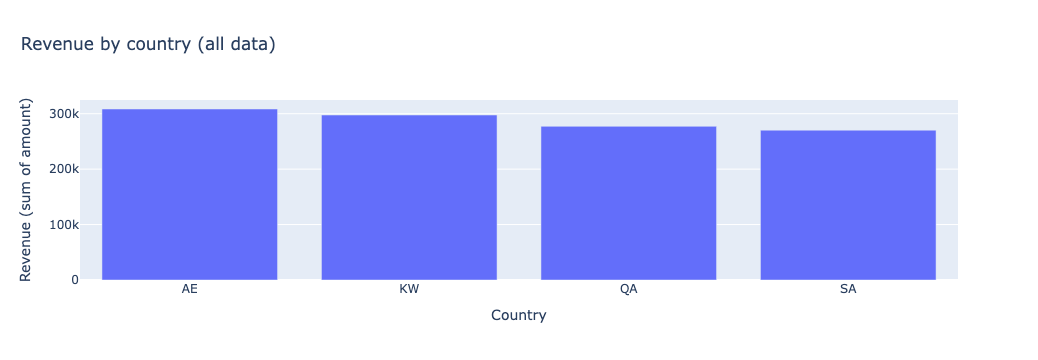

In [6]:
fig = px.bar(
    rev,
    x="country",
    y="revenue",
    title="Revenue by country (all data)"
)

fig.update_layout(title_x=0.02)
fig.update_xaxes(title_text="Country")
fig.update_yaxes(title_text="Revenue (sum of amount)")



The chart compares total revenue across countries and shows that AE and KW have slightly higher revenue than QA and SA.

In [7]:
save_fig(fig, FIGS / "revenue_by_country.png")

Task 5 — Question 2: Revenue trend (monthly)

This chart illustrates the monthly trend of total revenue across the dataset.

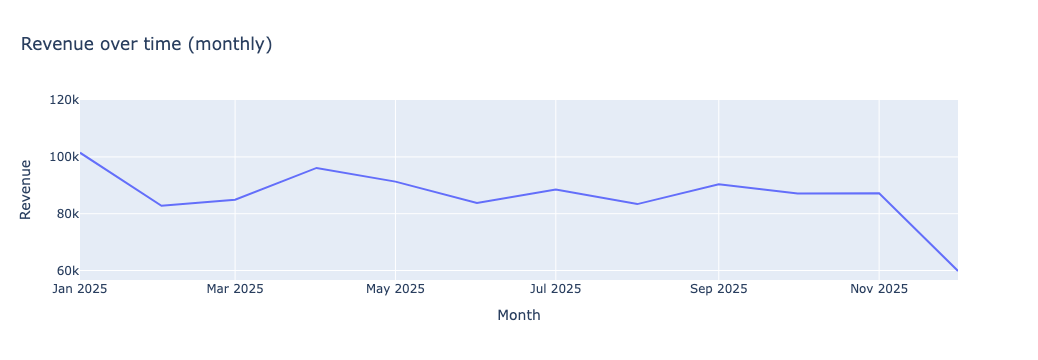

In [8]:
trend = (
    df.groupby("month", dropna=False)
      .agg(
          n=("order_id", "size"),
          revenue=("amount", "sum"),
      )
      .reset_index()
      .sort_values("month")
)

fig = px.line(
    trend,
    x="month",
    y="revenue",
    title="Revenue over time (monthly)"
)

fig.update_layout(title={"x": 0.02})
fig.update_xaxes(title_text="Month")
fig.update_yaxes(title_text="Revenue")

save_fig(fig, FIGS / "revenue_trend_monthly.png")
fig

The chart shows how total revenue varies from month to month.

Task 5 — Question 3: Amount distribution (winsorized)

This histogram shows the distribution of order amounts after winsorization.

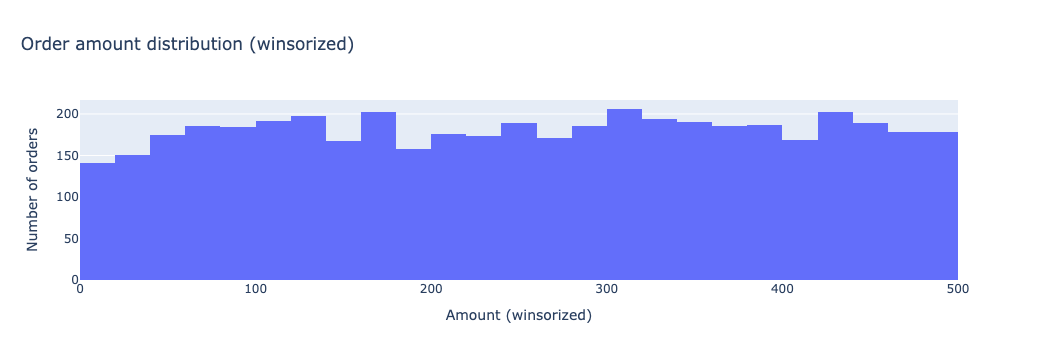

In [9]:
fig = px.histogram(
    df,
    x="amount_winsor",
    nbins=30,
    title="Order amount distribution (winsorized)"
)

fig.update_layout(title={"x": 0.02})
fig.update_xaxes(title_text="Amount (winsorized)")
fig.update_yaxes(title_text="Number of orders")

save_fig(fig, FIGS / "amount_hist_winsor.png")
fig

This histogram shows the distribution of order amounts after winsorization.

Task 6 — Bootstrap comparison 

A bootstrap comparison was performed to estimate the difference in mean refund rates between the two groups.

In [10]:
import numpy as np

def bootstrap_diff_means(a, b, *, n_boot=2000, seed=0):
    rng = np.random.default_rng(seed)
    diffs = []

    for _ in range(n_boot):
        sa = rng.choice(a, size=len(a), replace=True)
        sb = rng.choice(b, size=len(b), replace=True)
        diffs.append(sa.mean() - sb.mean())

    diffs = np.array(diffs)

    return {
        "diff_mean": float(a.mean() - b.mean()),
        "ci_low": float(np.quantile(diffs, 0.025)),
        "ci_high": float(np.quantile(diffs, 0.975)),
    }


d = df.assign(
    is_refund=df["status_clean"]
        .fillna("")         
        .eq("refund")
        .astype(int)
)

a = d.loc[d["country"].eq("SA"), "is_refund"]
b = d.loc[d["country"].eq("AE"), "is_refund"]

print("n_SA:", len(a), "n_AE:", len(b))

res = bootstrap_diff_means(a, b, n_boot=2000, seed=0)
print(res)

n_SA: 1164 n_AE: 1283
{'diff_mean': -0.006885574777757239, 'ci_low': -0.031390684553224434, 'ci_high': 0.016756009058451374}


The bootstrap results suggest that the difference in mean refund rates between SA and AE is not statistically significant.